In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
from io import BytesIO
import os
import streamlit as st
import pickle
from tensorflow import keras


In [2]:
# Read the data files
listing_data = pd.read_csv("current_farfetch_listings.csv")

In [3]:
listing_data.head()

,Unnamed: 0,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,...,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.installmentsLabel,priceInfo.isOnSale,shortDescription,stockTotal
0,0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,...,SGD,NaN,1080,"$1,080","$1,080",1080,NaN,False,logo print strap sandals,130
1,1,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",2049368,Self-Portrait,women,True,13784566,https://cdn-images.farfetch-contents.com/13/78...,https://cdn-images.farfetch-contents.com/13/78...,False,...,SGD,20% Off,392,$392,$490,490,NaN,True,embroidered midi dress,14
2,2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,...,SGD,NaN,1245,"$1,245","$1,245",1245,NaN,False,FendiMania sock style sneakers,68
3,3,"[{'scaleId': 0, 'size': 'One Size'}]",49486,A.P.C.,women,False,13744082,https://cdn-images.farfetch-contents.com/13/74...,https://cdn-images.farfetch-contents.com/13/74...,False,...,SGD,20% Off,308,$308,$385,385,NaN,True,top zip wallet,1
4,4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,...,SGD,NaN,1248,"$1,248","$1,248",1248,NaN,False,slingback 65 pumps,78


In [4]:
# Check the shape of data (num_rows, num_colums)
listing_data.shape

(188817, 23)

In [5]:
# drop the unnames: 0 column
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Check for dtypes
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

In [7]:
# Drop priceInfo.installmentsLabel
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [8]:
# Check for % of null values
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [9]:
# Analyse the null variables
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabel,...,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
9,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",1504165,Rejina Pyo,women,True,13777585,https://cdn-images.farfetch-contents.com/13/77...,https://cdn-images.farfetch-contents.com/13/77...,False,New Season,...,9359,SGD,NaN,989,$989,$989,989,False,Blake herringbone midi dress,16
11,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2747,Chloé,women,True,13704528,https://cdn-images.farfetch-contents.com/13/70...,https://cdn-images.farfetch-contents.com/13/70...,False,New Season,...,9359,SGD,NaN,1790,"$1,790","$1,790",1790,False,pussy-bow rose-jacquard blouse,14
13,"[{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...",168996,Pleats Please By Issey Miyake,women,True,14107224,https://cdn-images.farfetch-contents.com/14/10...,https://cdn-images.farfetch-contents.com/14/10...,False,New Season,...,9359,SGD,NaN,657,$657,$657,657,False,pleated midi dress,13
15,NaN,769627,Burberry,women,True,13970008,https://cdn-images.farfetch-contents.com/13/97...,https://cdn-images.farfetch-contents.com/13/97...,False,New Season,...,9359,SGD,NaN,1000,"$1,000","$1,000",1000,False,Margrette 50mm cow print pumps,10
18,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2765,Alexander McQueen,women,True,13951735,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,New Season,...,9359,SGD,NaN,3330,"$3,330","$3,330",3330,False,tie-neck houndstooth midi-dress,2


In [10]:
# Check for the categories in merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: merchandiseLabel, dtype: int64

In [11]:
# Drop the column merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [12]:
# Analysing priceInfo.discountLabel
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,NoTag,9359,SGD,NaN,1080,"$1,080","$1,080",1080,False,logo print strap sandals,130
2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,NoTag,9140,SGD,NaN,1245,"$1,245","$1,245",1245,False,FendiMania sock style sneakers,68
4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,NoTag,9339,SGD,NaN,1248,"$1,248","$1,248",1248,False,slingback 65 pumps,78
6,"[{'scaleId': 0, 'size': 'One Size'}]",25354,Gucci,women,True,12562558,https://cdn-images.farfetch-contents.com/12/56...,https://cdn-images.farfetch-contents.com/12/56...,False,NoTag,10952,SGD,NaN,3740,"$3,740","$3,740",3740,False,Green Dionysus GG small velvet shoulder bag,61
7,"[{'scaleId': 0, 'size': 'One Size'}]",1025204,MCM,women,True,13768073,https://cdn-images.farfetch-contents.com/13/76...,https://cdn-images.farfetch-contents.com/13/76...,False,NoTag,9913,SGD,NaN,1323,"$1,323","$1,323",1323,False,logo print satchel,5


In [13]:
# fill the null values in priceInfo.discountLabel with 0
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [14]:
# drop the size column
listing_data.drop('availableSizes', axis=1, inplace=True)

In [15]:
# Check for null values again
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [16]:
# Extracting the Image 
def load_images():
    
    # Store the directory path in a variable
    cutout_img_dir = "C:/Users/SATYO/Music/DCD_21/cutout-img/cutout"
    model_img_dir = "C:/Users/SATYO/Music/DCD_21/model-img/model"
    
    # list the images in these directories
    cutout_images = os.listdir(cutout_img_dir)
    model_images = os.listdir(model_img_dir)
    
    # load 10 Random Cutout Images: Sample out 10 images randomly from the above list
    sample_cutout_images = sample(cutout_images,10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Cutout Images==============")
    for i, img_name in enumerate(sample_cutout_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(cutout_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()
    print()
    # load 10 Random Model Images: Sample out 10 images randomly from the above list
    sample_model_images = sample(model_images,10)
    fig = plt.figure(figsize=(10,5))
    
    print("==============Model Images==============")
    for i, img_name in enumerate(sample_model_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(model_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()

==============Cutout Images==============


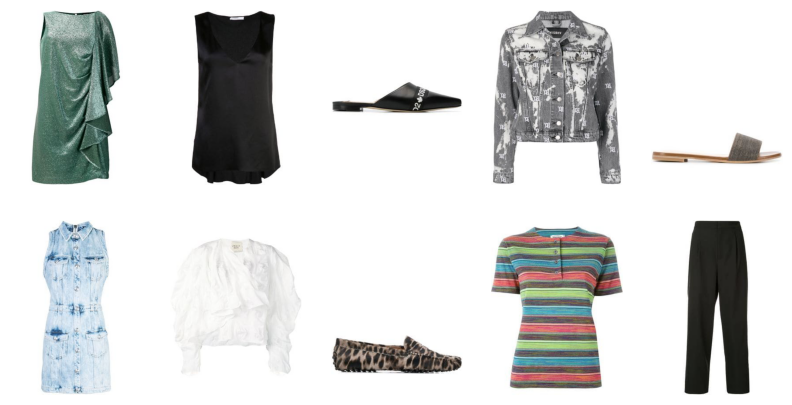


==============Model Images==============


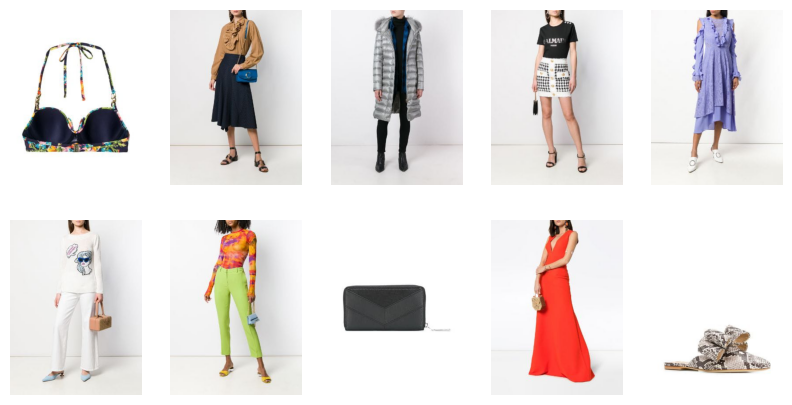

In [17]:
load_images()

In [18]:
# Join the images with path and add in the dataframe

# Store the directory path in a varaible
cutout_img_dir = "C:/Users/SATYO/Music/DCD_21/cutout-img/cutout"
model_img_dir = "C:/Users/SATYO/Music/DCD_21/model-img/model"

# list the directories
cutout_images = os.listdir(cutout_img_dir)
model_images = os.listdir(model_img_dir)

In [19]:
def extractImageName(x):
    
    # 1. Invert the image path
    x_inv = x[ :: -1]
    
    # 2. Find the index of '/'
    slash_idx = x_inv.find('/')
    
    # 3. Extract the text after the -slash_idx
    return x[-slash_idx : ] 

listing_data['cutOutimageNames'] = listing_data['images.cutOut'].apply(lambda x : extractImageName(x))
listing_data['modelimageNames'] = listing_data['images.model'].apply(lambda x : extractImageName(x))

In [20]:
# Extract only those data points for which we have images
listing_data = listing_data[listing_data['cutOutimageNames'].isin(cutout_images)]
listing_data = listing_data[listing_data['modelimageNames'].isin(model_images)]

In [21]:
# Reset the index
listing_data.reset_index(drop=True, inplace=True)

In [22]:
# Add entire paths to cutOut and modelImages
listing_data['cutOutImages_path'] = cutout_img_dir + '/' + listing_data['cutOutimageNames']
listing_data['modelImages_path'] = model_img_dir + '/' + listing_data['modelimageNames']

In [23]:
# Drop the cutOutimageNames, cutOutimageNames
listing_data.drop(['cutOutimageNames', 'cutOutimageNames'], axis=1, inplace=True)

The images show a high waisted skinny jeans 
Price: $323
Brand: Rag & Bone



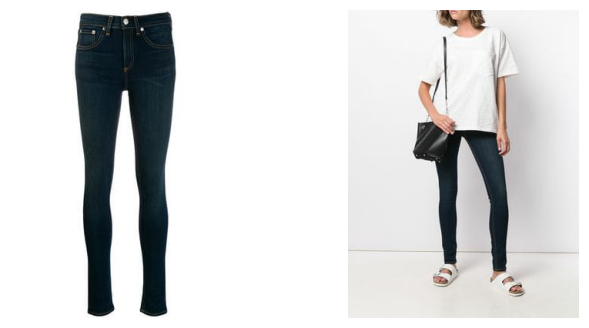

In [24]:
# Plot the images along with product descriptions, price and brand
random_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
cutOut_img_path = listing_data.iloc[random_idx]['cutOutImages_path']
model_img_path = listing_data.iloc[random_idx]['modelImages_path']
price = listing_data.iloc[random_idx]['priceInfo.formattedFinalPrice']
desc = listing_data.iloc[random_idx]['shortDescription']
brand = listing_data.iloc[random_idx]['brand.name']

# Load the images
cutOut_img = image.load_img(cutOut_img_path)
cutOut_img_arr = image.img_to_array(cutOut_img, dtype='int')
model_img = image.load_img(model_img_path)
model_img_arr = image.img_to_array(model_img, dtype='int')

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
print("The images show a {}".format(desc))
print("Price: {}".format(price))
print("Brand: {}".format(brand))
print()
ax[0].imshow(cutOut_img_arr)
ax[1].imshow(model_img_arr)
ax[0].axis('off')
ax[1].axis('off')
plt.show()


In [25]:
# Creating a class for feature extraction and finding the most similar images



class FeatureExtractor:
    
    # Constructor
    def __init__(self, arch='ResNet'):
        
        self.arch = arch
        
             
        
        if self.arch == 'ResNet':
            base_model = ResNet50(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
        
        
        elif self.arch == 'Xception':
            base_model = Xception(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
            
    
    # Method to extract image features
    def extract_features(self, img):
        
        
        if self.arch == 'VGG' or self.arch == 'ResNet':
            img = img.resize((224, 224))
        elif self.arch == 'Xception':
            img = img.resize((299, 299))
        
        # Convert the image channels from to RGB
        img = img.convert('RGB')
        
        # Convert into array
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        if self.arch == 'VGG':
            # Proprocess the input as per vgg 16
            x = vgg_preprocess(x)
            
        elif self.arch == 'ResNet':
            # Proprocess the input as per ResNet 50
            x = resnet_preprocess(x)
            
        elif self.arch == 'Xception':
            # Proprocess the input as per ResNet 50
            x = xception_preprocess(x)
        
                
        # Extract the features
        features = self.model.predict(x) 
        
        # Scale the features
        features = features / np.linalg.norm(features)
        
        return features      


In [26]:
# Extract the features for a sample of 10000 images
index_values = np.random.randint(low = 0, high = (listing_data.shape[0] - 1), size = 5000)
modelImages = listing_data.iloc[index_values]['modelImages_path']

In [27]:
def MAP(similarity_metric_arr, threshold=1.0, k = 10):

  # List to store precision at k
  precision_at_k = []

  # 1. Check if the distance <= threshold
  for similarity_metric in similarity_metric_arr:

    if similarity_metric <= threshold:
      precision_at_k.append(1)

    else:
      precision_at_k.append(0)
  

  mean_average_precision = np.mean(precision_at_k)
  return mean_average_precision

In [28]:
resnet_feature_extractor = FeatureExtractor(arch='ResNet')

# dictionary to store the features and index of the image
image_features_resnet = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = resnet_feature_extractor.extract_features(img)
    image_features_resnet[idx] = feature




1/1 [==============================] - 0s 110ms/step


In [29]:
# save the model to disk
filename = 'resnet_model.pkl'
pickle.dump(image_features_resnet, open(filename, 'wb'))

In [30]:
# Create a query
queryImage_idx = np.random.choice(index_values)
queryImage_path = listing_data.iloc[queryImage_idx]['modelImages_path']
queryImage = image.load_img(queryImage_path)

# Extract Features from queryImage

# 1. ResNet
queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)


1/1 [==============================] - 0s 113ms/step


In [31]:
# 1. ResNet
similarity_images_resnet = {}
for idx, feat in image_features_resnet.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5
    
similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
top_10_simiarity_scores_resnet = [score for _, score in similarity_resnet_sorted][ : 10]
top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]


========================================== QUERY IMAGE ===============================================


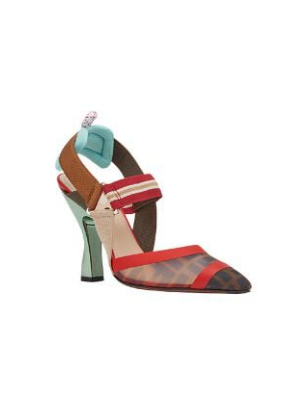

In [32]:
print("========================================== QUERY IMAGE ===============================================")
plt.figure(figsize=(5,5))
plt.imshow(image.img_to_array(queryImage, dtype='int'))
plt.axis('off')
plt.show()


print("======================================================================================================")
print()


#ResNet
top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']
map_resnet = MAP(top_10_simiarity_scores_resnet, threshold=0.55, k=10)

========================================== ResNet Results =============================================


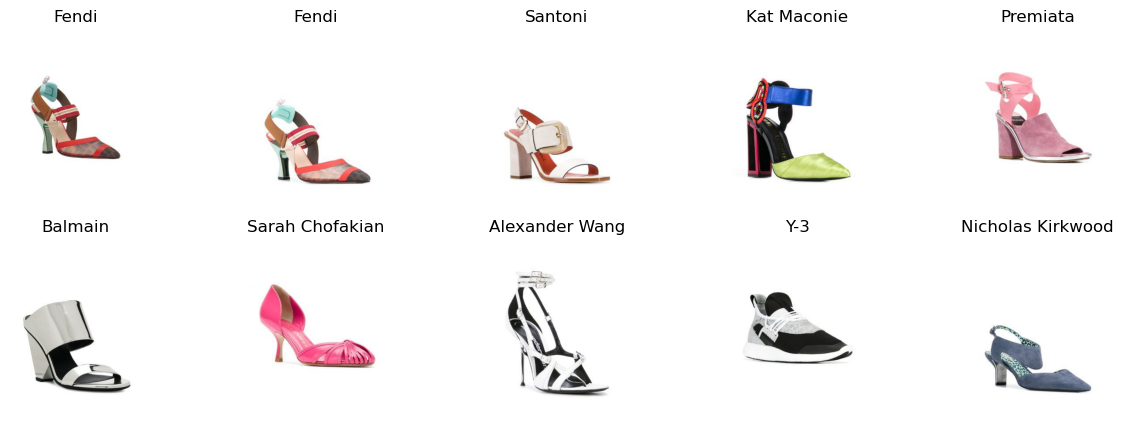

The images show a high waisted skinny jeans 
Price: $323
Brand: Nicholas Kirkwood




In [33]:
print("========================================== ResNet Results =============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Resnet, brand_Resnet)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off')
plt.show()
print("The images show a {}".format(desc))
print("Price: {}".format(price))
print("Brand: {}".format(brand))
print("======================================================================================================")
print()
print()




In [34]:
print("MAP Score for ResNet: {}".format(map_resnet))

MAP Score for ResNet: 0.2


In [35]:
def testModel(input_file):
    
    # Testing the architectures on external images
    
    '''Read the inserted url'''
    
    testing_img = Image.open(input_file)
     
    
      
    testing_features = resnet_feature_extractor.extract_features(testing_img)
    
    similarity_images_resnet = {}
    for idx, feat in image_features_resnet.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_resnet[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
    brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']
    price_Resnet = listing_data.iloc[top_10_indexes_resnet]['priceInfo.formattedFinalPrice']
    desc_Resnet = listing_data.iloc[top_10_indexes_resnet]['shortDescription']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(4,4))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.show()
    

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand,price) in enumerate(zip(top_10_similar_imgs_Resnet,brand_Resnet,price_Resnet)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

In [36]:
testModel.pickle = "testModel.pkl"

In [37]:
with open(testModel.pickle, 'wb') as file:  
    pickle.dump(testModel, file)

1/1 [==============================] - 0s 81ms/step
===================== QUERY IMAGE ==========================


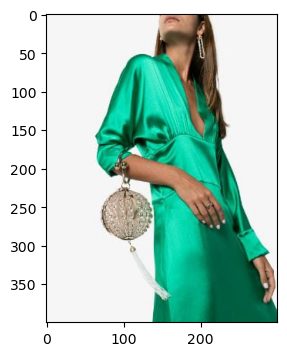

===================== SIMILAR IMAGES ==========================


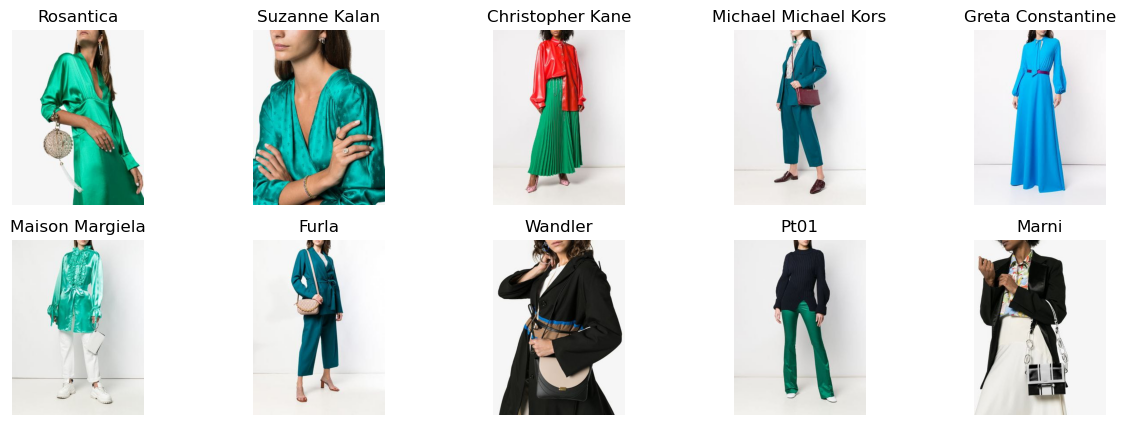

In [45]:
# Call the function
directory_image = r"C:\Users\SATYO\Music\DCD_21\model-img\model\14056115_20201867_300.jpg"
testModel(directory_image)

In [39]:
with open("resnet_model.pkl", 'rb') as file:  
    image_features_resnet=pickle.load(file)

1/1 [==============================] - 0s 80ms/step
===================== QUERY IMAGE ==========================


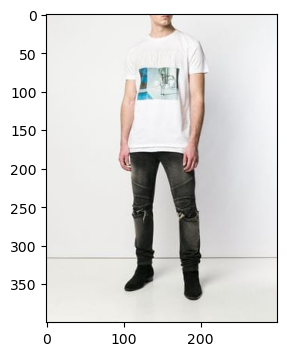

===================== SIMILAR IMAGES ==========================


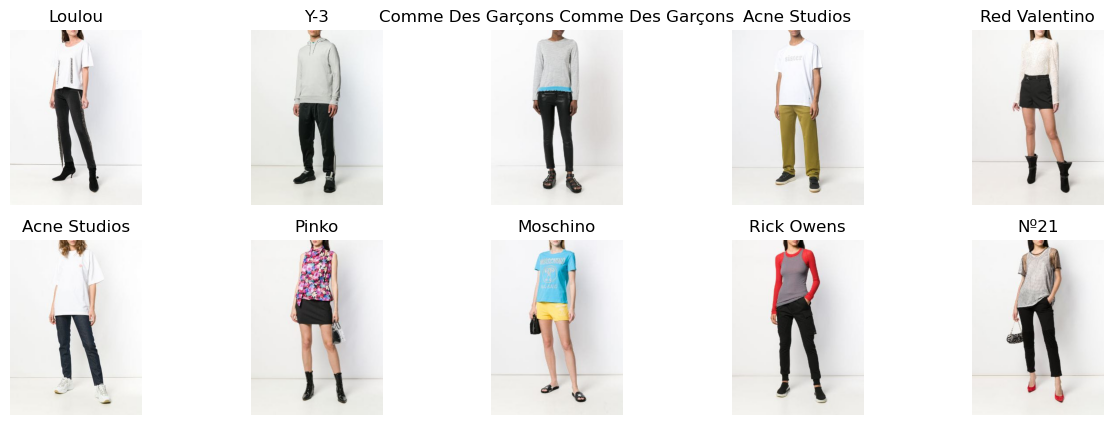

In [40]:
# Call the function
directory_image = r"C:\Users\SATYO\Music\DCD_21\model-img\model\13658969_17856518_300.jpg"
testModel(directory_image)

In [41]:
def testModel2(img_url):
    
    # Testing the architectures on external images
    
 
        
    '''Read the inserted url'''
    img_url = img_url
    response = requests.get(img_url)
    testing_img = Image.open(BytesIO(response.content))
      
    testing_features = resnet_feature_extractor.extract_features(testing_img)
    
    similarity_images_resnet = {}
    for idx, feat in image_features_resnet.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_resnet[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
    brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']
    price_Resnet = listing_data.iloc[top_10_indexes_resnet]['priceInfo.formattedFinalPrice']
    desc_Resnet = listing_data.iloc[top_10_indexes_resnet]['shortDescription']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(4,4))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.show()
    

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand,price) in enumerate(zip(top_10_similar_imgs_Resnet,brand_Resnet,price_Resnet)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 330ms/step
===================== QUERY IMAGE ==========================


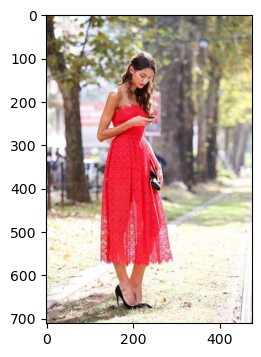

===================== SIMILAR IMAGES ==========================


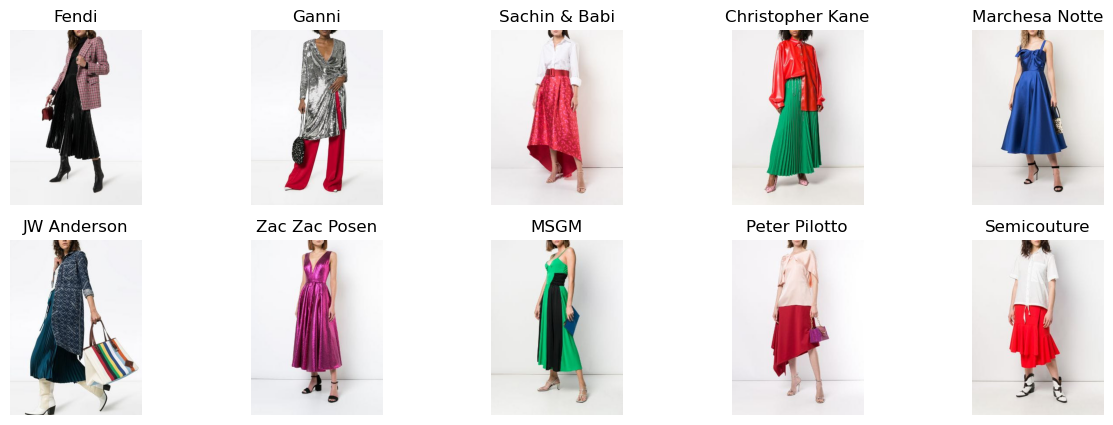

In [51]:
# Call the function
link_image = "https://th.bing.com/th/id/OIP.TiagwQTlBu6FiHkoDLYtrwHaLH?rs=1&pid=ImgDetMain"
testModel2(link_image)

In [43]:
def testModel3(camera_input):
    
    # Testing the architectures on external images
    
 
        
    '''Read the inserted url'''
    camera_input = camera_input
    response = requests.get(camera_input)
    testing_img = Image.open(BytesIO(response.content))
      
    testing_features = resnet_feature_extractor.extract_features(testing_img)
    
    similarity_images_resnet = {}
    for idx, feat in image_features_resnet.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_resnet[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
    brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']
    price_Resnet = listing_data.iloc[top_10_indexes_resnet]['priceInfo.formattedFinalPrice']
    desc_Resnet = listing_data.iloc[top_10_indexes_resnet]['shortDescription']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(4,4))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.show()
    

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand,price) in enumerate(zip(top_10_similar_imgs_Resnet,brand_Resnet,price_Resnet)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

In [48]:
def testModel5(input_file,source):
    
    # Testing the architectures on external images
    if source == 'url':
        response == requests.get(input_file)
        testing_img == Image.open(BytesIO(response.content))

    elif source == 'upload':
        testing_img = Image.open(input_file)

    else: print("error")
     
      
        
    testing_features = resnet_feature_extractor.extract_features(testing_img)
    
    similarity_images_resnet = {}
    for idx, feat in image_features_resnet.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_resnet[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
    brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']
    price_Resnet = listing_data.iloc[top_10_indexes_resnet]['priceInfo.formattedFinalPrice']
    desc_Resnet = listing_data.iloc[top_10_indexes_resnet]['shortDescription']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(4,4))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.show()
    

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand,price) in enumerate(zip(top_10_similar_imgs_Resnet,brand_Resnet,price_Resnet)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

In [49]:
# Call the function
link_image = "https://th.bing.com/th/id/OIP.TiagwQTlBu6FiHkoDLYtrwHaLH?rs=1&pid=ImgDetMain"
testModel5(link_image)

TypeError: testModel5() missing 1 required positional argument: 'source'